# Use Simulators/Quantum Computers hosted on AWS Braket

With PennyLane as interface of Q-Trainer, we can use various simulators/quantum computers available on [AWS Braket](https://aws.amazon.com/braket/).

Here we show a list of available devices with their Amazon Resource Names (ARNs).

+ Simulators (CPUs)
    + State-Vector Simulators: for pure-state simulations
        + SV1: `arn:aws:braket:::device/quantum-simulator/amazon/sv1`
    + Tensor-Network Simulators: for pure-state simulations (faster than SV1 for sparsely-connected qubits)
        + TN1: `arn:aws:braket:::device/quantum-simulator/amazon/tn1`
    + Density-Matrix Simulators: for mixed-state simulations
        + DM1: `arn:aws:braket:::device/quantum-simulator/amazon/dm1`
+ Quantum Computers (QPUs)
    + Rigetti
        + Aspen M-2 (80 Qubits): `arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2`
        + Aspen M-3 (79 Qubits): `arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3`
    + IonQ
        + IonQ Device (11 Qubits): `arn:aws:braket:::device/qpu/ionq/ionQdevice`
      
    

In this tutorial, we use a QAOA problem as an example to demonstrate the use of QPUs from AWS Braket.

In [1]:
import qtrainer
import networkx as nx
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

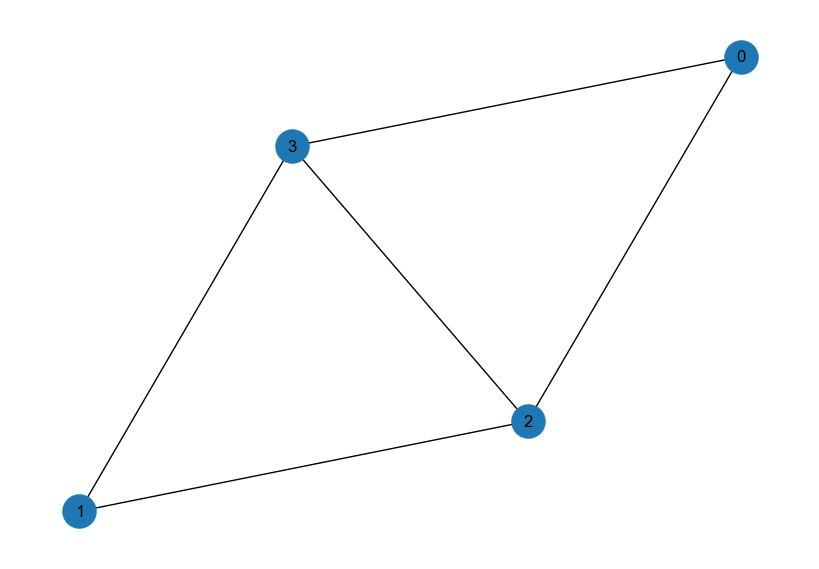

In [9]:
n_nodes = 4
p = 0.5  # probability of an edge
seed = 1967
g = nx.erdos_renyi_graph(n_nodes, p=p, seed=seed)
positions = nx.spring_layout(g, seed=seed)
nx.draw(g, with_labels=True, pos=positions, node_size=600)
task = "maxcut"
depth = 1
circuit = qtrainer.circuits.QAOACircuit(graph=g, task=task, depth=depth, seed=0)

In [10]:
noise_gate = qml.DepolarizingChannel
noise_strength = 0.1
noise_fn = qml.transforms.insert(noise_gate, noise_strength, position="all")

## Trainer
+ `circuit`: Q-Trainer Circuit class
+ `device_name`: Pennylane-stype device name. (For noised simulation, use `default.mixed`/`cirq.mixedsimulator`/`braket_dm`.)
+ `optimizer`: could be `Adam`, `SGD`, `ShotAdaptive`, `SPSA`, etc.
+ `noise_fn`: preset noise function
+ `error_mitigation_method`: Quantum error mitigation method. Currently, only Zero-Noise Zxtrapolation (`zne`) is supported
+ `n_steps`: number of optimization steps

In [11]:
train_config = dict(
    optimizer = 'Adam',
    optimizer_config={'stepsize': 1},
    n_steps = 100,
    shots_per_step = 1000,
    eval_freq = 5,

)
device_config = { "poll_timeout_seconds":1800,}

We train the circuit using a local simulator.

In [12]:
trainer = qtrainer.Trainer(circuit, device_name = 'lightning.qubit',
                           **train_config,)
_ = trainer.train()

Train:   0%|          | 0/100 [00:00<?, ?it/s]

Obtain measurement samples from the trained circuit.

In [13]:
cpu_samples = trainer.sample_measurement(shots=1000)

### Use AWS Braket QPU

Here we run the trained circuit on a quantum computer (i.e., QPU), Rigetti Apsen M-3, hosted on AWS Braket.

In [16]:
device_config['device_arn']='arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3'
qpu_trainer = qtrainer.Trainer(circuit, device_name = 'braket.aws.qubit',device_config=device_config,
                                 error_mitigation_method='zne',
                           **train_config,)

Obtain measurement samples from the QPU.

In [17]:
qpu_samples = qpu_trainer.sample_measurement(shots=100)

## Evaluation
Here we show the measurement probabilities for different configurations.

In [20]:
def cut_size(measurement, graph):
    S = np.argwhere(measurement == 1).flatten()
    T = np.argwhere(measurement == 0).flatten()
    return nx.cut_size(graph, S, T)

def est_measurement_prob(measurements,shots=10000):
    shots = 10000
    wires = trainer.n_qubits
    s = measurements.T.numpy()
    s = (1 - s) / 2
    s = map(tuple, s)
    counts = Counter(s)
    indx = np.ndindex(*[2] * wires)
    probs = {p: counts.get(p, 0) / shots for p in indx}
    return probs
def plot_maxcut_results(probs,cuts,n_qubits:int,title=None):
    plt.style.use("seaborn")
    labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(probs))]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(range(2 ** n_qubits), probs.values(),label='Measurement Probability')
    normalized_cuts = np.array(list(cuts.values())) / max(list(cuts.values())) * max(list(probs.values()))*1.1
    ax.set_xticks([i for i in range(len(probs))], labels, rotation='vertical', size=12)
    # ax.set_yticks(size=12)

    ax.set_xlabel("Sample", size=20)
    ax.set_ylabel("Probability", size=20)

    # ax2 = plt.twinx()
    ax.bar(range(2 ** n_qubits), normalized_cuts, alpha=0.2, color='orange',label='Cut Size')

    # ax2.set_yticks(np.linspace(0,normalized_cuts.max(),)
    ax.set_title(title,size=20)
    plt.legend(prop={'size': 15})
    
    fig = plt.gcf()
    fig.set_size_inches(16, 8)
    return fig

+ Result of the local simulator

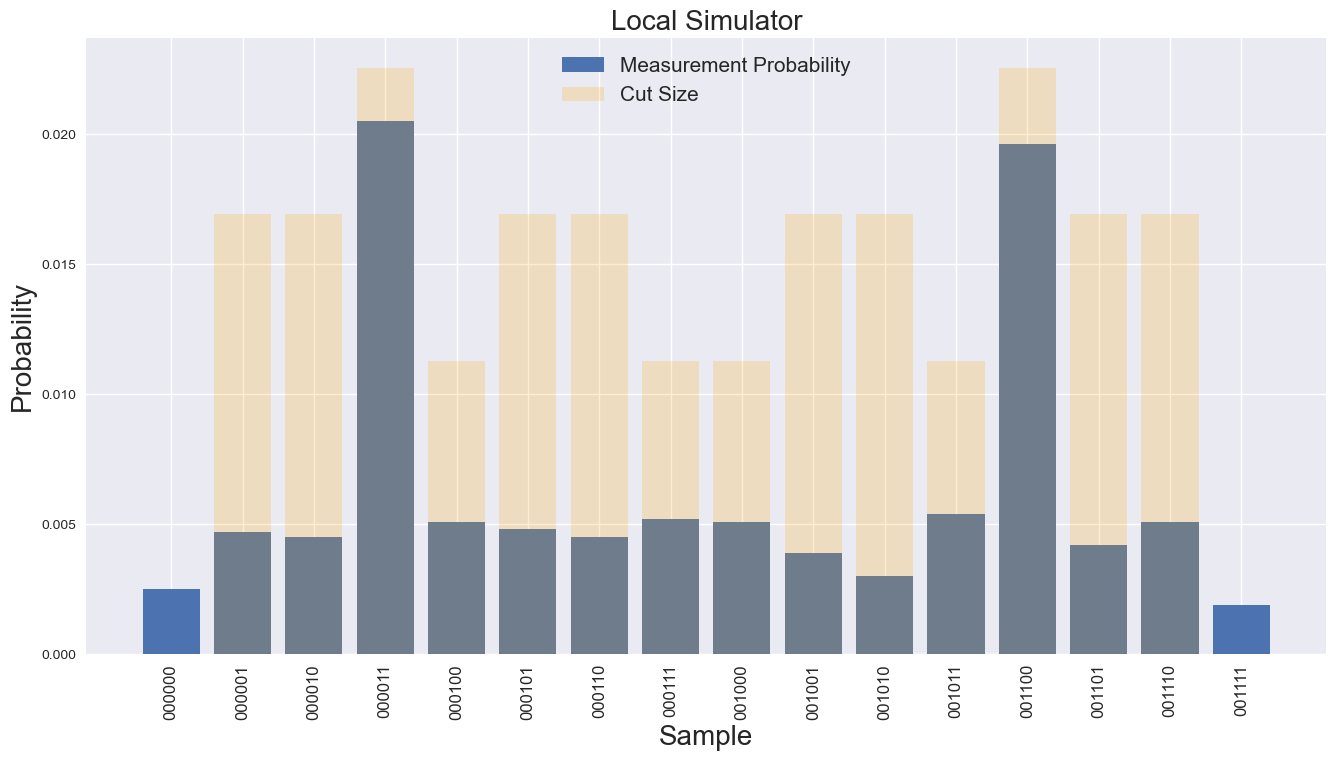

In [23]:
probs = est_measurement_prob(cpu_samples)
cuts = {k: cut_size(np.array(k), g) for k in probs.keys()}
fig_base = plot_maxcut_results(probs,cuts,n_qubits=n_nodes,title='Local Simulator')

+ Result of the QPU

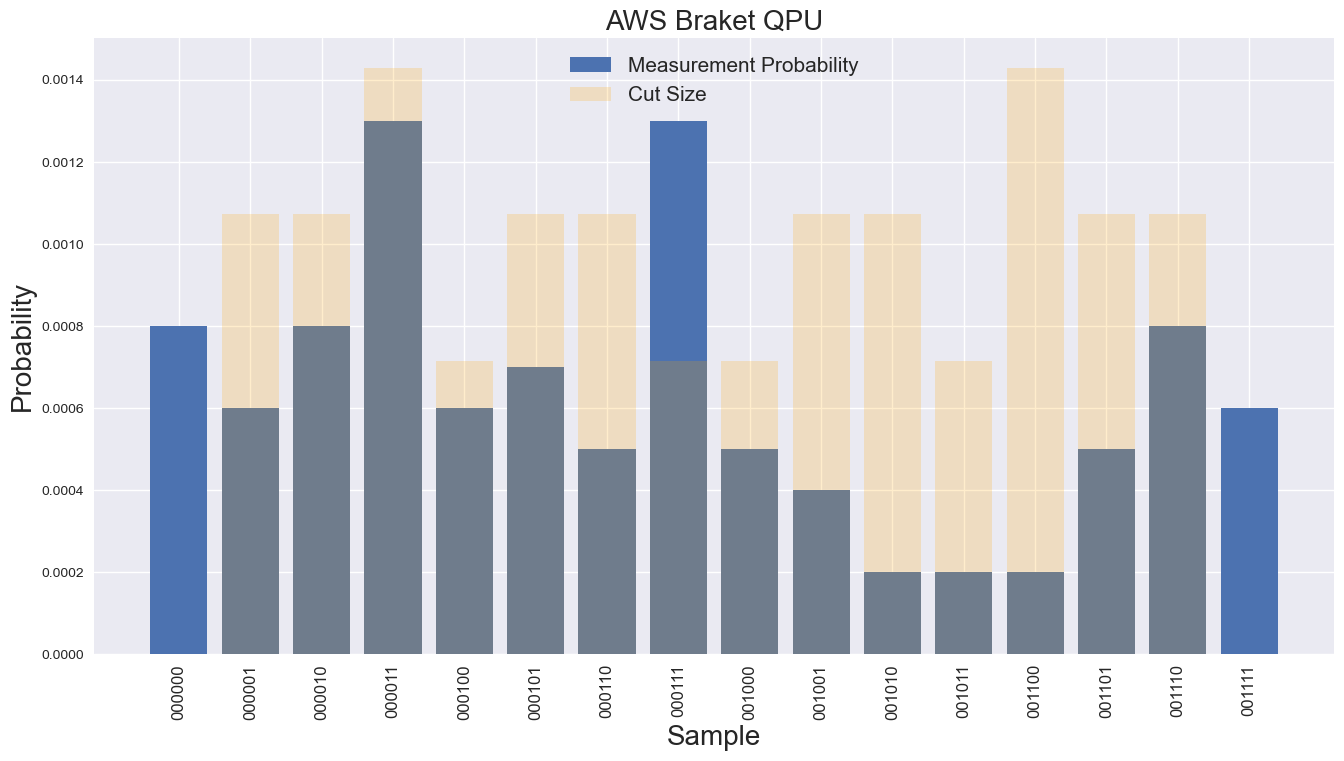

In [24]:
probs = est_measurement_prob(qpu_samples)
cuts = {k: cut_size(np.array(k), g) for k in probs.keys()}
fig_base = plot_maxcut_results(probs,cuts,n_qubits=n_nodes,title='AWS Braket QPU')